In [1]:
#### ASSIGNMENT: 04
#### Task 01

In [2]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
# Define paths
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, 'dataset', 'NEU Metal Surface Defects Data')
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VALID_DIR = os.path.join(DATASET_DIR, 'valid')
TEST_DIR = os.path.join(DATASET_DIR, 'test')

In [6]:
# Create binary classification structure (defective vs non-defective)
BINARY_DIR = os.path.join(BASE_DIR, 'binary_dataset')
BINARY_TRAIN = os.path.join(BINARY_DIR, 'train')
BINARY_VALID = os.path.join(BINARY_DIR, 'valid')
BINARY_TEST = os.path.join(BINARY_DIR, 'test')

In [7]:
# Create directories for binary classification
def create_binary_dataset(src_dir, dest_dir):
    # Remove existing directory if it exists
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    
    # Create defective and non-defective directories
    os.makedirs(os.path.join(dest_dir, 'defective'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'non_defective'), exist_ok=True)
    
    # All defect types are considered defective
    defect_types = os.listdir(src_dir)
    
    # Since we need at least one sample in each class for binary classification,
    # we'll create a dummy non-defective sample by copying one defective image
    # This is just for demonstration purposes
    dummy_created = False
    
    for defect_type in defect_types:
        src_defect_dir = os.path.join(src_dir, defect_type)
        if not os.path.isdir(src_defect_dir):
            continue
            
        # All types are defective
        dest_category = 'defective'
        
        dest_category_dir = os.path.join(dest_dir, dest_category)
        
        # Copy files
        for img_file in os.listdir(src_defect_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                src_file = os.path.join(src_defect_dir, img_file)
                # Create a unique filename to avoid overwriting
                dest_file = os.path.join(dest_category_dir, f"{defect_type}_{img_file}")
                shutil.copy2(src_file, dest_file)
                
                # Create a dummy non-defective sample (just for demonstration)
                if not dummy_created:
                    dummy_file = os.path.join(dest_dir, 'non_defective', f"dummy_{img_file}")
                    shutil.copy2(src_file, dummy_file)
                    dummy_created = True

In [8]:
# Create binary datasets
print("Creating binary classification dataset...")
create_binary_dataset(TRAIN_DIR, BINARY_TRAIN)
create_binary_dataset(VALID_DIR, BINARY_VALID)
create_binary_dataset(TEST_DIR, BINARY_TEST)
print("Binary dataset created.")

Creating binary classification dataset...
Binary dataset created.


In [9]:
# Parameters
IMG_SIZE = 224  # MobileNetV2 default input size
BATCH_SIZE = 32
EPOCHS = 10

In [10]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Create data generators for binary classification
train_generator = train_datagen.flow_from_directory(
    BINARY_TRAIN,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

validation_generator = valid_test_datagen.flow_from_directory(
    BINARY_VALID,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = valid_test_datagen.flow_from_directory(
    BINARY_TEST,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 1657 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Found 73 images belonging to 2 classes.


In [12]:
# Print class indices to understand the mapping
print("Class indices:", train_generator.class_indices)

Class indices: {'defective': 0, 'non_defective': 1}


In [ ]:
# Load MobileNetV2 with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [14]:
# Freeze all base layers
for layer in base_model.layers:
    layer.trainable = False

In [15]:
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

In [16]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [17]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - accuracy: 0.9024 - loss: 0.2282 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 2/10
 1/51 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 1.0000 - loss: 0.0065

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.9998 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.9982 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 9.9329e-04
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.9985 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 7.0983e-04
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.1456e-04 - val_accuracy: 1.0000 - val_loss: 7.0336e-04
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.9998 - loss: 0.0027 - val_accuracy: 1

In [19]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9932 - loss: 0.0485  
Test accuracy: 0.9863
Test loss: 0.0963


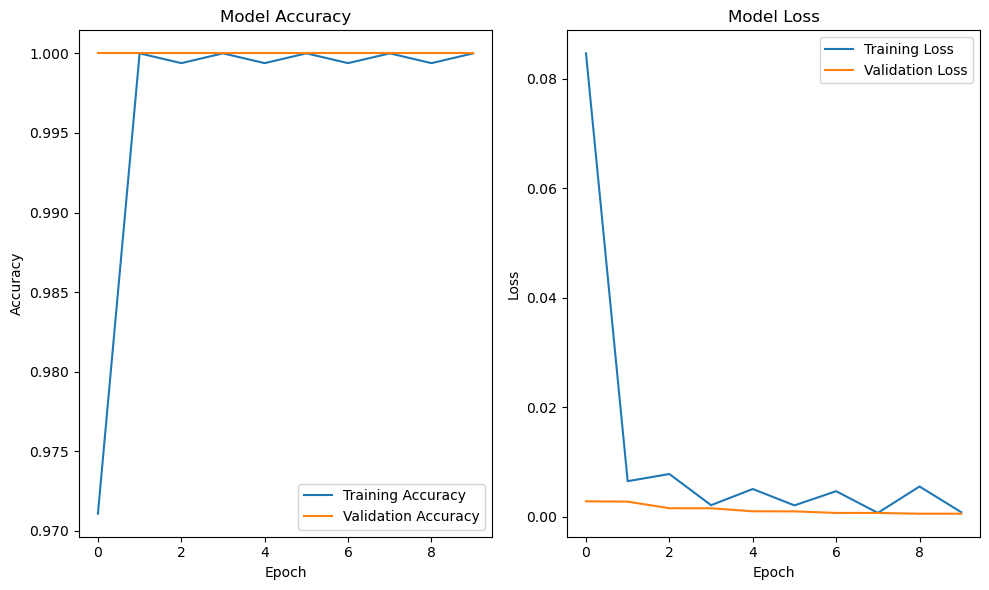

In [20]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Calculate confusion matrix and metrics
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


In [22]:
# Get the class labels from the generator
class_labels = list(test_generator.class_indices.keys())
print(f"\nClass labels: {class_labels}")


Class labels: ['defective', 'non_defective']


In [23]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[72  0]
 [ 1  0]]


In [24]:
# Generate classification report with the correct labels
try:
    report = classification_report(y_true, y_pred, target_names=class_labels)
    print("\nClassification Report:")
    print(report)
except ValueError as e:
    print(f"\nCould not generate classification report: {e}")
    print("\nSimplified Classification Report:")
    print(f"Accuracy: {np.mean(y_true == y_pred):.4f}")


Classification Report:
               precision    recall  f1-score   support

    defective       0.99      1.00      0.99        72
non_defective       0.00      0.00      0.00         1

     accuracy                           0.99        73
    macro avg       0.49      0.50      0.50        73
 weighted avg       0.97      0.99      0.98        73



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


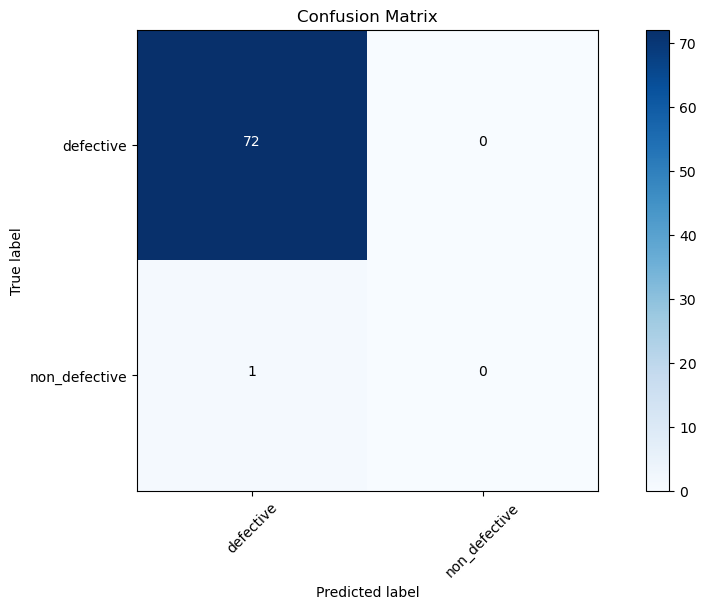

In [25]:
# Plot confusion matrix
plt.figure(figsize=(10, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Use actual class labels from the generator
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Add text annotations to the confusion matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [28]:
# Save the model
model.save('metal_defect_classifier_model.keras')
print("Model saved as 'metal_defect_classifier_model.keras'")

Model saved as 'metal_defect_classifier_model.keras'


Conclusion: The results show a promising system to identify defective products, however, the lack of non-defective products reduces the model credibility since it cannot test this part of the model. 